In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/kaggle/input/videoframedata/new_frame_data.csv')
df.head()

In [ ]:
len(df)

In [ ]:
df['class'].value_counts()

In [ ]:
df['frame_path'][8]

In [ ]:
!pip install  -q unsloth

In [ ]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs

import torch

In [ ]:
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2-VL-7B-Instruct",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

In [ ]:
import json

# Define the output path for the JSONL file
output_path = "/kaggle/working/dataset.json"

# Convert the dataset to JSONL format
with open(output_path, "w") as f:
    for _, row in df.iterrows():
        json_data = {
            "image_path": row["frame_path"],  # Path to the frame image
            "question": row["question"],     # Question about the frame
            "answer": row["refined_answer"]  # Refined answer
        }
        f.write(json.dumps(json_data) + "\n")

print(f"JSONL file saved to: {output_path}")

In [ ]:
data = []
with open(output_path, "r") as f:
    for line in f:
        data.append(json.loads(line))

In [ ]:
image_path = data[9]["image_path"]
question = data[9]["question"]
answer = data[9]["answer"]

print(f"Image Path: {image_path}")
print(f"Question: {question}")
print(f"Answer: {answer}")

In [31]:
import json
from tqdm import tqdm
from PIL import Image

# Instruction for the dataset
instruction = "Answer the question based on the content of this image."

# Function to convert a single sample into a conversation format
def convert_to_conversation(sample):
    try:
        # Load the image using PIL
        image = Image.open(sample["image_path"])
        expected_size = (224, 224)
        # Resize the image
        image = image.resize(expected_size)
        
        conversation = [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": instruction},
                    {"type": "image", "image": image}, # Pass the resized image
                    {"type": "text", "text": sample["question"]}
                ]
            },
            {
                "role": "assistant",
                "content": [
                    {"type": "text", "text": sample["answer"]}
                ]
            },
        ]
        return {"messages": conversation}
    except Exception as e:
        print(f"Error processing image {sample['image_path']}: {e}")
        return None # Skip the image if there's an error

# Convert dataset with tqdm progress bar
converted_dataset = [convert_to_conversation(sample) for sample in tqdm(data, desc="Processing Samples")]
converted_dataset = [sample for sample in converted_dataset if sample is not None] #remove errored images


Processing Samples: 100%|██████████| 55244/55244 [21:03<00:00, 43.72it/s] 


In [36]:
converted_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Answer the question based on the content of this image.'},
    {'type': 'image', 'image': <PIL.Image.Image image mode=RGB size=224x224>},
    {'type': 'text',
     'text': 'What specific outfits are the people wearing?'}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'The performers are adorned in traditional Newari clothing, featuring vibrant red and yellow garments, along with elaborate masks symbolizing various deities like Kali Bhairav, Ganesh, and Kumari.'}]}]}

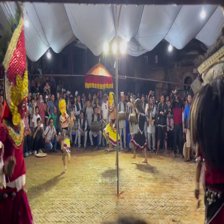

In [48]:
converted_dataset[3]['messages'][0]['content'][1]['image']

In [39]:
from PIL import Image
from transformers import TextStreamer

# Enable the model for inference
model = FastVisionModel.for_inference(model)

# Load the image as a PIL image
image = converted_dataset[0]['messages'][0]['content'][1]['image']

print(image)

# Prepare instruction and messages
instruction = "Answer the question based on the content of this image."
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},  # Pass the resized PIL image directly
            {"type": "text", "text": instruction}
        ]
    }
]

input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
print(input_text)

inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")
print(inputs)

# Define the text streamer
text_streamer = TextStreamer(
    tokenizer=tokenizer,
    skip_prompt=True  # Skip showing the input prompt in the output
)
print(text_streamer)

# Generate the output
with torch.no_grad():  # Disable gradient computation during inference
    _ = model.generate(**inputs, streamer=text_streamer, max_new_tokens=128,
                       use_cache=True, temperature=1.5, min_p=0.1)

<PIL.Image.Image image mode=RGB size=224x224 at 0x7C31BFCB6E30>
<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>Answer the question based on the content of this image.<|im_end|>
<|im_start|>assistant

{'input_ids': tensor([[151644,   8948,    198,   2610,    525,    264,  10950,  17847,     13,
         151645,    198, 151644,    872,    198, 151652, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 15

In [41]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 30,
        # num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

In [42]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
11.242 GB of memory reserved.


In [43]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 55,244 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 4
\        /    Total batch size = 4 | Total steps = 30
 "-____-"     Number of trainable parameters = 50,855,936
🦥 Unsloth needs about 1-3 minutes to load everything - please wait!


Step,Training Loss
1,2.613200
2,2.755100
3,2.666800
4,2.810700
5,2.905400
6,2.479200
7,2.268000
8,2.145800
9,1.962400
10,1.843300


In [44]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

269.8591 seconds used for training.
4.5 minutes used for training.
Peak reserved memory = 11.242 GB.
Peak reserved memory for training = 0.0 GB.
Peak reserved memory % of max memory = 76.263 %.
Peak reserved memory for training % of max memory = 0.0 %.


In [55]:
from transformers import TextStreamer

# Enable the model for inference
model = FastVisionModel.for_inference(model)

# Load the image as a PIL image
image = converted_dataset[1500]['messages'][0]['content'][1]['image']

print(image)

# Prepare instruction and messages
instruction = "Which dance is begin performed?"
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},  # Pass the resized PIL image directly
            {"type": "text", "text": instruction}
        ]
    }
]

input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
print(input_text)

inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")
print(inputs)

# Define the text streamer
text_streamer = TextStreamer(
    tokenizer=tokenizer,
    skip_prompt=True  # Skip showing the input prompt in the output
)
print(text_streamer)

# Generate the output
with torch.no_grad():  # Disable gradient computation during inference
    _ = model.generate(**inputs, streamer=text_streamer, max_new_tokens=128,
                       use_cache=True, temperature=1.5, min_p=0.1)

<PIL.Image.Image image mode=RGB size=224x224 at 0x7C3154581270>
<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>Which dance is begin performed?<|im_end|>
<|im_start|>assistant

{'input_ids': tensor([[151644,   8948,    198,   2610,    525,    264,  10950,  17847,     13,
         151645,    198, 151644,    872,    198, 151652, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151653,  23085,
          

In [50]:
model.save_pretrained("/kaggle/working/qwen_model")
tokenizer.save_pretrained("/kaggle/working/qwen_model")

[]